Loading Premier League table...


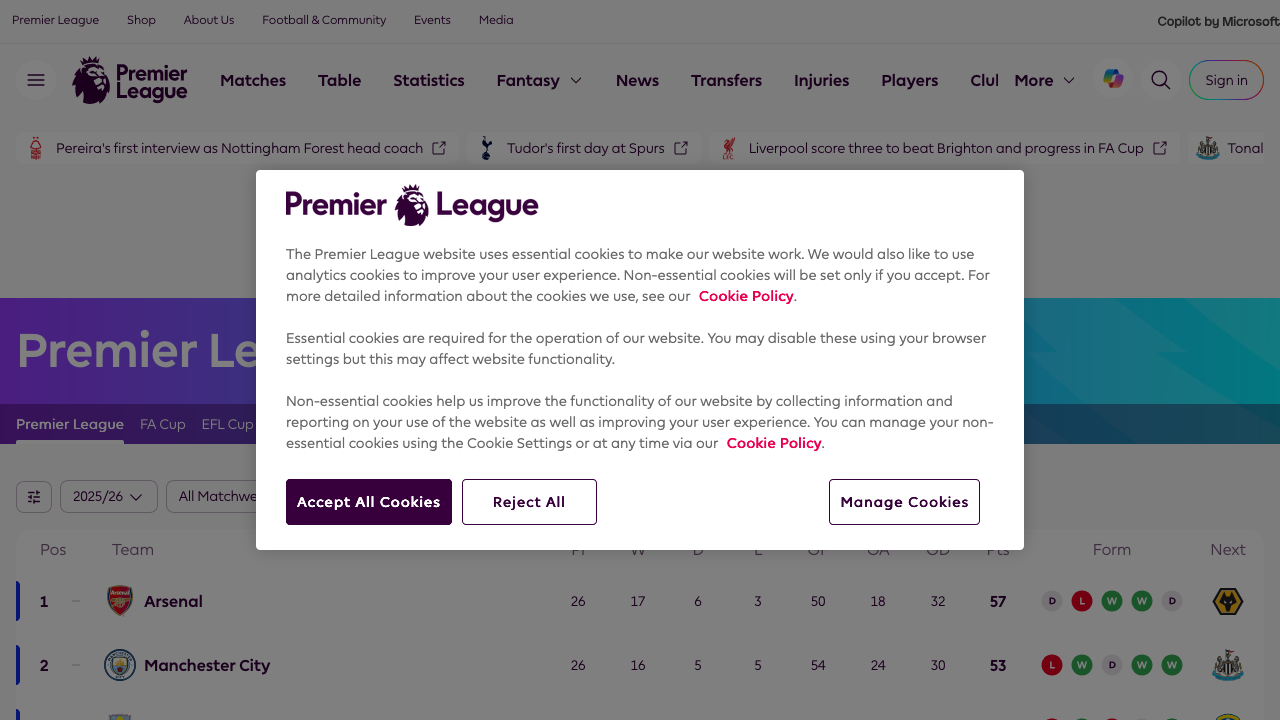

Found 20 teams.
Saved CSV as output_csvs/premier_league_2025_26_markdown.csv


,Position,Team_MD,Played,Won,Drawn,Lost,Goals For,Goals Against,Goal Difference,Points,Logo URL
0,1,![Arsenal](https://resources.premierleague.com...,26,17,6,3,50,18,32,57,https://resources.premierleague.com/premierlea...
1,2,![Manchester City](https://resources.premierle...,26,16,5,5,54,24,30,53,https://resources.premierleague.com/premierlea...
2,3,![Aston Villa](https://resources.premierleague...,26,15,5,6,37,27,10,50,https://resources.premierleague.com/premierlea...
3,4,![Manchester United](https://resources.premier...,26,12,9,5,47,37,10,45,https://resources.premierleague.com/premierlea...
4,5,![Chelsea](https://resources.premierleague.com...,26,12,8,6,47,30,17,44,https://resources.premierleague.com/premierlea...


In [17]:
import asyncio
import requests
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display, Image

async def scrape_and_save_markdown():
    # 1️⃣ Load the page with Playwright
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        print("Loading Premier League table...")
        await page.goto(
            "https://www.premierleague.com/en/tables/premier-league/2025-26",
            wait_until="networkidle"
        )
        screenshot = await page.screenshot()
        display(Image(screenshot))
        content = await page.content()
        await browser.close()
    
    # 2️⃣ Parse with BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")
    rows = soup.find_all("tr", {"data-testid": "standingsRow"})
    print("Found", len(rows), "teams.")

    # 3️⃣ Extract stats + logo URLs
    data = []
    for row in rows:
        try:
            position = row.find("div", {"data-testid": "standingsRowPosition"}).text.strip()
            team_name = row.find("span", {"data-testid": "standingsTeamName"}).text.strip()
            played = row.find("div", {"data-testid": "standingsRowStatPlayed"}).text.strip()
            won = row.find("div", {"data-testid": "standingsRowStatWon"}).text.strip()
            drawn = row.find("div", {"data-testid": "standingsRowStatDrawn"}).text.strip()
            lost = row.find("div", {"data-testid": "standingsRowStatLost"}).text.strip()
            goals_for = row.find("div", {"data-testid": "standingsRowStatGoalFor"}).text.strip()
            goals_against = row.find("div", {"data-testid": "standingsRowStatGoalAgainst"}).text.strip()
            goal_diff = row.find("div", {"data-testid": "standingsRowStatGoalDifference"}).text.strip()
            points = row.find("div", {"data-testid": "standingsRowPoints"}).text.strip()
            logo_url = row.find("img", {"alt": lambda x: x and "club badge" in x})["src"]
            
            data.append({
                "Position": position,
                "Team": team_name,
                "Played": played,
                "Won": won,
                "Drawn": drawn,
                "Lost": lost,
                "Goals For": goals_for,
                "Goals Against": goals_against,
                "Goal Difference": goal_diff,
                "Points": points,
                "Logo URL": logo_url
            })
        except Exception as e:
            print(f"Skipping a row due to error: {e}")

    df = pd.DataFrame(data)

    # 4️⃣ Create Markdown column for Datawrapper
    df['Team_MD'] = df.apply(
        lambda row: f'![{row["Team"]}]({row["Logo URL"]}) {row["Team"]}',
        axis=1
    )

    # 5️⃣ Rearrange columns
    df = df[[
        "Position", "Team_MD", "Played", "Won", "Drawn", "Lost",
        "Goals For", "Goals Against", "Goal Difference", "Points", "Logo URL"
    ]]

    # 6️⃣ Save CSV
    output_csv = "output_csvs/premier_league_2025_26_markdown.csv"
    df.to_csv(output_csv, index=False)
    print(f"Saved CSV as {output_csv}")

    display(df.head())

# Run the scraper
await scrape_and_save_markdown()
